In [1]:
from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
from skimage.measure import compare_ssim as ssim
import matplotlib.pyplot as plt
import time
import os
import copy
import h5py
import sys
import torch
from PIL import Image
import gc

sys.path.append('../../../code')

from python.finetune_commons import show_images, ft_train_model, visualize_model
from python.commons import load_dict_from_hdf5, save_dict_to_hdf5, inc_inference_e2e, full_inference_e2e, adaptive_drilldown, generate_heatmap
from python.vgg16 import VGG16

%matplotlib inline

/usr/local/lib/python2.7/dist-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
n_labels = 2
gpu = True
image_size = 224
c = 0.5
file_paths = [
    '../../../data/oct/DRUSEN_NORMAL/validation/DRUSEN/DRUSEN-5333808-1.jpeg',
    '../../../data/oct/DRUSEN_NORMAL/validation/DRUSEN/DRUSEN-1020679-5.jpeg',
    '../../../data/oct/DRUSEN_NORMAL/validation/DRUSEN/DRUSEN-1112835-10.jpeg',
    '../../../data/oct/DRUSEN_NORMAL/validation/DRUSEN/DRUSEN-1130960-76.jpeg',
    '../../../data/oct/DRUSEN_NORMAL/validation/DRUSEN/DRUSEN-1169820-1.jpeg',
    '../../../data/oct/DRUSEN_NORMAL/validation/DRUSEN/DRUSEN-1146923-28.jpeg',
    '../../../data/oct/DRUSEN_NORMAL/validation/NORMAL/NORMAL-1007507-1.jpeg',
    '../../../data/oct/DRUSEN_NORMAL/validation/NORMAL/NORMAL-1007507-1.jpeg',
    '../../../data/oct/DRUSEN_NORMAL/validation/NORMAL/NORMAL-1007507-1.jpeg',
    '../../../data/oct/DRUSEN_NORMAL/validation/NORMAL/NORMAL-1001772-3.jpeg'    
]

In [3]:
loader = transforms.Compose([transforms.Resize([image_size, image_size]), transforms.ToTensor()])

orig_image = torch.FloatTensor(len(file_paths), 3, image_size, image_size)

for i,file_path in enumerate(file_paths):
    temp_image = Image.open(file_path).convert('RGB')
    temp_image = loader(temp_image)
    orig_image[i] = temp_image
    
if gpu:
    orig_image = orig_image.cuda()

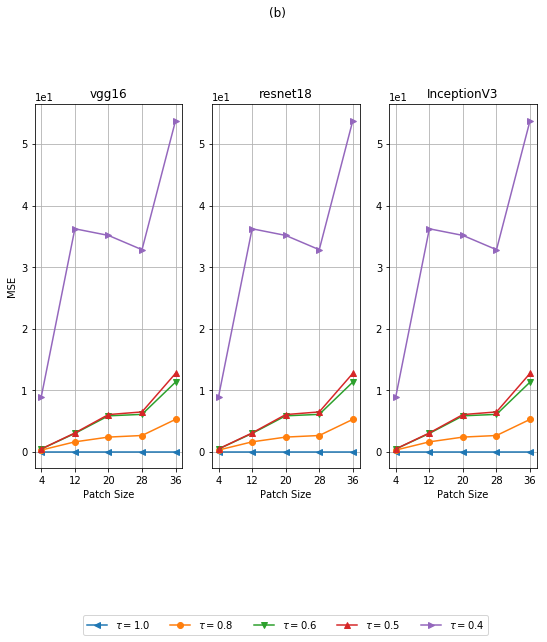

In [11]:
patch_sizes = [4, 12, 20, 28, 36]
markers = ['<', 'o', 'v', '^', '>']

plt.figure(figsize=(9,2.5))

i = 1

for model,model_name in zip([VGG16, VGG16, VGG16], ['vgg16', 'resnet18', 'InceptionV3']):

    for beta,m in zip([1.0, 0.8, 0.6, 0.5, 0.4], markers):        
        r = []
        ax = plt.subplot(1, 3, i)
        for patch_size in patch_sizes:
            
            image_patches = torch.FloatTensor(3, patch_size, patch_size).fill_(c).repeat(len(file_paths), 1, 1, 1)

            ####### tau=1.0 #######                
            locations = torch.zeros([1, 2], dtype=torch.int32)
            locations[0][0] = (image_size-patch_size)//2
            locations[0][1] = (image_size-patch_size)//2

            temp_weights_data = load_dict_from_hdf5('../../../exps/oct_drusen_vgg16_ptch.h5', gpu=True)
            weights_data = load_dict_from_hdf5('../../../code/python/vgg16_weights_ptch.h5', gpu=True)
            weights_data['fc8_W:0'] = temp_weights_data['fc8_W:0']
            weights_data['fc8_b:0'] = temp_weights_data['fc8_b:0']

            inc_model = model(beta=1.0, gpu=gpu, n_labels=n_labels, weights_data=weights_data)
            inc_model.forward_materialized(orig_image)
            logits_10 = inc_model.forward_gpu(image_patches, locations, p_height=patch_size, p_width=patch_size)

            ###### tau <= 1.0 ######
            locations = torch.zeros([1, 2], dtype=torch.int32)
            locations[0][0] = (image_size-patch_size)//2
            locations[0][1] = (image_size-patch_size)//2

            temp_weights_data = load_dict_from_hdf5('../../../exps/oct_drusen_vgg16_ptch.h5', gpu=True)
            weights_data = load_dict_from_hdf5('../../../code/python/vgg16_weights_ptch.h5', gpu=True)
            weights_data['fc8_W:0'] = temp_weights_data['fc8_W:0']
            weights_data['fc8_b:0'] = temp_weights_data['fc8_b:0']
            
            inc_model = model(beta=beta, gpu=gpu, n_labels=n_labels, weights_data=weights_data)
            inc_model.forward_materialized(orig_image)
            logits = inc_model.forward_gpu(image_patches, locations, p_height=patch_size, p_width=patch_size)

            temp = logits_10 - logits
            temp = temp.cpu().data.numpy()
            temp = np.square(temp)
            temp = np.sum(temp)
            
            r.append(temp/len(file_paths))

        plt.plot(patch_sizes, r, label=r'$\tau = $' + str(beta), marker=m)
        ax.set_title(model_name)
        plt.ticklabel_format(style='sci', axis='y', scilimits=(0,0))

    plt.grid()
    plt.xlabel('Patch Size')
    plt.xticks(patch_sizes, patch_sizes)

    if i == 1:
        plt.ylabel('MSE')

    i = i + 1
    
lgd = plt.legend(loc='lower center', bbox_to_anchor=(-0.7, -0.47), ncol=5)
plt.suptitle('(b)')
plt.subplots_adjust(top=0.8)
plt.savefig('../images/mse_thresholding.pdf', bbox_extra_artists=(lgd,), bbox_inches='tight')
plt.show()